# Programming Assignment #5: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the type of flowers in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `chapter09_part03_interpreting-what-convnets-learn.ipynb`. You can download from https://github.com/fchollet/deep-learning-with-python-notebooks.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU (Unless you have a GPU on your machine). This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. Register to Kaggle (https://www.kaggle.com/) to collect the datset used in this experiment. It is free and you will have access to lots of datasets. If you do not want to register, go to step 2.
2. Download the Flower corpus:
   * Either from Kaggle if you have registered (https://www.kaggle.com/alxmamaev/flowers-recognition). 
   * Or use a local copy, `flower-recognition.zip`, in the `datasets` folder in canvas.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
   * Start with the partition available in the canvas folder (`flower_split.zip`); or
   * Run the code in the cells below (recommended).


In [100]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name. Use the name colab is you run the code from Google colab
machine_name = 'filip'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [101]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

In [102]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'filip':
    base = 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [103]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


['C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\daisy',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\dandelion',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\rose',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\sunflower',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\tulip']

We build the (image, label) pairs

In [104]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('100080576_f52e8ee070_n.jpg', 'daisy'),
 ('10140303196_b88d3d6cec.jpg', 'daisy'),
 ('10172379554_b296050f82_n.jpg', 'daisy'),
 ('10172567486_2748826a8b.jpg', 'daisy'),
 ('10172636503_21bededa75_n.jpg', 'daisy'),
 ('102841525_bd6628ae3c.jpg', 'daisy'),
 ('10300722094_28fa978807_n.jpg', 'daisy'),
 ('1031799732_e7f4008c03.jpg', 'daisy'),
 ('10391248763_1d16681106_n.jpg', 'daisy'),
 ('10437754174_22ec990b77_m.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [105]:

random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

2590
863
864


We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [106]:
if False:
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the training set. You can start from the architecture proposed by Chollet, Listing 8.7 (in Chollet's notebook chapter 8), and a small number of epochs. Use the `Rescaling` layer to scale your images as in the book:
```
layer.Rescaling(1.255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [107]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.image import ResizeMethod

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

In [111]:
# TODO: Set batch size 64
train_dataset = keras.preprocessing.image_dataset_from_directory(
    os.path.join(base ,
        "flowers_split" ,
        "train")
    ,
    image_size=(255, 255),
    batch_size=64)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    os.path.join(base, "flowers_split", "validation"),
    image_size=(255, 255),
    batch_size=64)

test_dataset = keras.preprocessing.image_dataset_from_directory(
    os.path.join(base, "flowers_split", "test"),
    image_size=(255, 255),
    batch_size=64)

Found 3632 files belonging to 5 classes.
Found 1555 files belonging to 5 classes.
Found 1563 files belonging to 5 classes.


Create the network and compile it

In [108]:
inputs = keras.Input(shape=(255, 255, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(test_dataset.class_names), activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Compile your network

In [109]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [110]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 460800)           

Create now the data readers for the training, validation, and test sets

You will now fit your model. Before, you will define a callback as in Chollet's book.

In [112]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [113]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
114/114 [==============================] - 98s 860ms/step - loss: 97.1721 - accuracy: 0.2437 - val_loss: 2.3066 - val_accuracy: 0.3389
Epoch 2/10
114/114 [==============================] - 97s 855ms/step - loss: 4.6759 - accuracy: 0.3676 - val_loss: 2.3746 - val_accuracy: 0.4039
Epoch 3/10
114/114 [==============================] - 96s 843ms/step - loss: 16.9429 - accuracy: 0.4860 - val_loss: 1.5857 - val_accuracy: 0.5466
Epoch 4/10
114/114 [==============================] - 96s 840ms/step - loss: 10.1430 - accuracy: 0.6044 - val_loss: 67.8792 - val_accuracy: 0.2296
Epoch 5/10
114/114 [==============================] - 99s 867ms/step - loss: 3.7021 - accuracy: 0.7123 - val_loss: 1.7684 - val_accuracy: 0.6611
Epoch 6/10
114/114 [==============================] - 98s 860ms/step - loss: 2.2424 - accuracy: 0.8034 - val_loss: 4.2842 - val_accuracy: 0.5595
Epoch 7/10
114/114 [==============================] - 98s 861ms/step - loss: 4.5653 - accuracy: 0.8331 - val_loss: 21.7545 - v

### Analyzing the fitting performance over epochs

As in Chollet's examples, show the training and validation loss

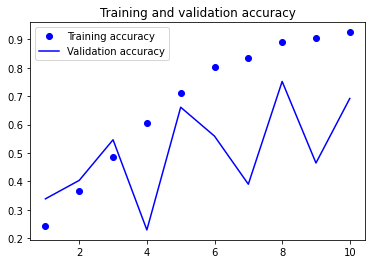

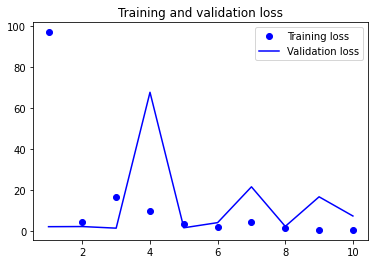

In [114]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

You will now apply now your network to the test set. Read the best model from your checkpoints

In [128]:
test_model = keras.models.load_model("lab5.keras")
test_loss_1, test_acc_1 = test_model.evaluate(validation_dataset)
print(f"Test accuracy: {test_acc_1:.3f}")

49/49 [==============================] - 17s 347ms/step - loss: 7.5207 - accuracy: 0.6920
Test accuracy: 0.692


Predict the test set classes. Call the matrix of prediction probabilities `Y_pred` and the predicted classes `y_pred`. While predicting, extract the annotations that you will call `y_true`.

In [132]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [117]:
Y_pred[:5]

array([[1.8220998e-25, 1.0000000e+00, 3.7659147e-26, 1.8727078e-20,
        3.6219516e-17, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.4875010e-19, 1.8521371e-16, 3.3158809e-14, 3.8000823e-21,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8438461e-08, 7.3273972e-05, 7.3421241e-08, 1.0088768e-15,
        9.9992657e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.3572572e-12, 9.9961227e-01, 3.1618985e-10, 5.0119361e-06,
        3.8274273e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.5168168e-13, 6.1097680e-06, 4.3579780e-09, 1.5601721e-05,
        9.9997830e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [131]:
y_pred[:20]

[4, 4, 2, 1, 3, 1, 0, 3, 1, 2, 2, 1, 4, 2, 4, 0, 0, 0, 1, 4]

In [126]:
y_true[:20]

array([1, 1, 3, 1, 0, 3, 3, 0, 2, 1, 1, 2, 4, 1, 4, 3, 0, 3, 4, 3])

Evaluate your model and report the loss and accuracy using Keras `evaluate()` function. You will store them in the `test_loss_1` and `test_acc_1` variables.

In [120]:
# Write your code here

In [121]:
test_loss_1, test_acc_1

(1.5311819314956665, 0.17530390620231628)

Report the accuracy as well as the classification report. Use sklearn functions this time.

In [133]:
from sklearn import metrics

print(test_acc_1)
print(metrics.classification_report(y_true, y_pred))


0.691961407661438
              precision    recall  f1-score   support

           0       0.22      0.19      0.20       316
           1       0.24      0.43      0.30       374
           2       0.19      0.18      0.19       282
           3       0.21      0.11      0.15       250
           4       0.24      0.14      0.18       341

    accuracy                           0.22      1563
   macro avg       0.22      0.21      0.20      1563
weighted avg       0.22      0.22      0.21      1563



Print the confusion matrix. Use a sklearn function

In [123]:
metrics.confusion_matrix(y_true, y_pred)

array([[ 47, 108,  40,  76,  45],
       [ 53, 124,  56,  81,  60],
       [ 45,  85,  34,  77,  41],
       [ 40,  88,  35,  55,  32],
       [ 53, 103,  53,  77,  55]], dtype=int64)

Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides built-in layers for this. You will reuse them and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 8.13 (in notebook 08 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

Write a sequence of transformation layers

In [124]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)



AttributeError: module 'tensorflow.keras.layers' has no attribute 'RandomFlip'

Define a model including these layers.

In [ ]:
inputs = keras.Input(shape=(255, 255, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_augmented = keras.Model(inputs=inputs, outputs=outputs)


Compile your network

In [ ]:
model_augmented.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_augmented.summary()

Define a callback to save your best model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5-augmented.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [ ]:
history_augmented = model_augmented.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [ ]:
accuracy = history_augmented.history["accuracy"]
val_accuracy = history_augmented.history["val_accuracy"]
loss = history_augmented.history["loss"]
val_loss = history_augmented.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

Load your best model

In [ ]:
test_model = keras.models.load_model("lab5-augmented.keras")

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [ ]:
test_loss_2, test_acc_2 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_2:.3f}")

In [ ]:
test_loss_2, test_acc_2

## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [ ]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))
conv_base.summary()

As in Chollet, Listing 8.20 (in Chollet's notebook 08), you will program a `get_features_and_labels()` function.

In [ ]:
# Write your code


The features and labels

In [ ]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [ ]:
# Write your code


In [ ]:
model.summary()

Compile your model

In [ ]:
# Write your code


Define a callback to save your best model

In [ ]:
# Write your code here


Fit your network

In [ ]:
# Write your code here


### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [ ]:
# Write your code here


Load your best model from the file

In [ ]:
# Write your code here


Evaluate your model and store the loss and accuracy in `test_loss_3`, `test_acc_3`

In [ ]:
# Write your code here


In [ ]:
test_loss_3, test_acc_3

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, use nadam or rmsprop as optimizer. Rescaling seems to lower the accuracy. Do not use it in your first attempts.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [ ]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))

You may want to try this first, and possibly modify it to improve the scores

In [ ]:
conv_base.trainable = False

Create an image augmentation

In [ ]:
# Write you code


Create your model

In [ ]:
# Write you code


Compile it

In [ ]:
# Write your code


In [ ]:
model.summary()

Write a callback to save your best model

In [ ]:
# Write your code here


Fit the model

In [ ]:
# Write your code


### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [ ]:
# write your code


Load your best model

In [ ]:
# Write your code here


Evaluate it and store the loss and accuracy in `test_loss_4` and `test_acc_4`

In [ ]:
# Write your code here


In [ ]:
test_loss_4, test_acc_4

### Predicting the test set

Apply now your network to the test set. You will collect `y_true` and `y_pred`

In [ ]:
# Write your code here


Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:
# write your code


Print the confusion matrix

In [ ]:
# write your code


## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [ ]:
(test_loss_1, test_acc_2), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

## Report

You will write a short report of about two pages on your experiments:
1. You will describe all the architectures you designed and the results you obtained. You will summarize the results in a table. Your description should be one-page long;
2. You will run Chollet's notebook chapter09_part3 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. Your analysis should be about one-page long.
3. You will run it on one of your flower images.

You will submit your report as well as your notebook through Canvas.